# Import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# import clip
from lavis.models import load_model_and_preprocess
from transformers import CLIPTokenizer, CLIPTextModel


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
from datetime import datetime

import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.path.abspath("")), "code"))
import lookup_dict as LD
import dataset as D

In [3]:
root_path = "/home/choi/BrainDecoder/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")
eeg_dataset_path = os.path.join(dataset_path, "eeg")

batch_size = 16
config = {"batch_size": batch_size}
blip_model, vis_processors = None, None

In [4]:
gpu_id = 2
device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"
print(device)

cuda:2


In [4]:
clip.available_models()
model, preprocess = clip.load("ViT-L/14")

In [5]:
model.to(device)
tokens = clip.tokenize(["hi"]).to(device)
x = model.encode_text(tokens)
print(x.shape)

torch.Size([1, 768])


In [6]:
y = torch.randn(1, 3, 5)
y.shape

torch.Size([1, 3, 5])

In [9]:
y[[0], [2]].shape

torch.Size([1, 5])

In [10]:
z = torch.randn(1, 77)
z.argmax(-1)

tensor([45])

# Dataset

In [5]:
if len(config.keys()) == 0:
    raise Exception("set config first")

dataset = D.EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")

loaders = {
    split: DataLoader(
        dataset=D.Splitter(dataset, split_name=split),
        batch_size=config["batch_size"],
        drop_last=True,
        shuffle=True if split == "train" else False,
        num_workers=23,
    )
    for split in ["train", "val", "test"]
}

# Model

In [ ]:
# clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [6]:
version = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(version)
transformer = CLIPTextModel.from_pretrained(version).to(device)

In [74]:
batch_encoding = tokenizer(
    ["text hello world"],
    truncation=True,
    max_length=77,
    return_length=True,
    return_overflowing_tokens=False,
    padding="max_length",
    return_tensors="pt",
)
tokens = batch_encoding["input_ids"].to(device)
outputs = transformer(input_ids=tokens)

z = outputs.last_hidden_state
# print(tokens)
# print(tokens.shape)
# print(z.shape)
# print(batch_encoding)

# print(
#     tokenizer.encode(
#         ["text hello world"],
#         truncation=True,
#         max_length=77,
#         return_length=True,
#         return_overflowing_tokens=False,
#         padding="max_length",
#         return_tensors="pt",
#     )
# )  # why all endoftext?
# print(tokenizer.decode(49406))
# print(tokenizer.decode(49407))
# print(tokenizer.decode([]))
# print(tokenizer.decode(tokens[0].tolist()))

print(outputs.last_hidden_state.shape)
print(outputs.last_hidden_state)

ft = outputs.last_hidden_state
ft = ft[0, tokens.argmax(dim=-1)]
# ft = ft[0,[0]]
print(ft[0, 0:5])
# print(ft.shape)

v = outputs.pooler_output
print(v.shape)
print(v[0, 0:5])

torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.1339, -1.4078,  0.5569,  ...,  0.8209,  0.5291, -0.0497],
         [ 0.9516,  0.2501, -0.8751,  ..., -0.6150, -0.9649, -0.8759],
         ...,
         [ 0.4748, -0.4474, -1.3124,  ...,  0.1735, -1.3134, -0.4175],
         [ 0.4939, -0.4396, -1.3075,  ...,  0.1705, -1.3051, -0.4185],
         [ 0.4672, -0.4577, -1.2850,  ...,  0.1511, -1.3429, -0.4734]]],
       device='cuda:2', grad_fn=<NativeLayerNormBackward0>)
tensor([ 0.6061, -0.5353,  0.0630, -0.0225, -2.1492], device='cuda:2',
       grad_fn=<SliceBackward0>)
torch.Size([1, 768])
tensor([ 0.6061, -0.5353,  0.0630, -0.0225, -2.1492], device='cuda:2',
       grad_fn=<SliceBackward0>)


In [47]:
class SampleLevelFeatureExtractorNN(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.save_hyperparameters()
        # seed_everything(seed,workers=True)

        self.input_size = 128
        self.hidden_size = 128
        # self.hidden_size = 768
        self.lstm_layers = config["lstm_layer"]
        self.out_size = 768 * 77
        # self.out_size = 768

        # self.lstm = nn.LSTM(input_size=128,hidden_size=128,num_layers=128)
        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            # nn.Linear(in_features=self.hidden_size, out_features=1000),
            # nn.ReLU(),
            # nn.Linear(in_features=768 * 30, out_features=self.out_size),
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

        # self.loss_fn = nn.CrossEntropyLoss()
        def l2_squared(x1, x2):
            # return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=1)
            return torch.mean(torch.pow(torch.subtract(x1, x2), 2))

        # self.loss_fn = l2_squared
        self.loss_fn = nn.MSELoss()
        self.cos = nn.CosineSimilarity()

        self.blip_caption_cache = {}

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        tmp_out = lstm_out[:, -1, :]
        out = self.output(tmp_out)
        out = out.reshape(out.size(0), 77, 768)
        # out = out.reshape(out.size(0), 1, 768)

        return out

    def training_step(self, batch, batch_idx):
        eegs, labels, img_names = batch

        eegs = eegs.to(device)
        eeg_embeddings = self(eegs)

        # get label clip embeddings
        labels = self.get_img_caption(labels, img_names, use_BLIP=config["use_blip"])
        # labels = clip.tokenize(labels).to(device)
        batch_encoding = tokenizer(
            labels,
            truncation=True,
            max_length=77,
            return_length=True,
            return_overflowing_tokens=False,
            padding="max_length",
            return_tensors="pt",
        )
        tokens = batch_encoding["input_ids"].to(device)
        outputs = transformer(input_ids=tokens)

        label_features = outputs.last_hidden_state

        # with torch.no_grad():
        #     label_features = clip_model.encode_text(labels)

        loss = self.loss_fn(eeg_embeddings, label_features)

        self.log_dict(
            {
                "train_loss": loss,
            },
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )
        return loss

    def on_train_epoch_end(self) -> None:
        self.log_dict(
            {
                "lr": self.scheduler.get_last_lr()[0],
            },
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )
        if config["tsne"]:
            if self.current_epoch % config["tsne_interval"] == 0:
                self.show_manifold()

    def validation_step(self, batch, batch_idx):
        eegs, labels, img_names = batch

        eegs = eegs.to(device)
        eeg_features = self(eegs)

        labels = self.get_img_caption(labels, img_names, use_BLIP=config["use_blip"])
        # labels = clip.tokenize(labels).to(device)
        batch_encoding = tokenizer(
            labels,
            truncation=True,
            max_length=77,
            return_length=True,
            return_overflowing_tokens=False,
            padding="max_length",
            return_tensors="pt",
        )
        tokens = batch_encoding["input_ids"].to(device)
        outputs = transformer(input_ids=tokens)

        label_features = outputs.last_hidden_state

        # with torch.no_grad():
        #     label_features = clip_model.encode_text(labels)

        loss = self.loss_fn(eeg_features, label_features)
        cos_sim = self.cos(eeg_features, label_features).mean()

        self.log_dict(
            {"val_loss": loss, "cos_sim": cos_sim},
            prog_bar=True,
            on_epoch=True,
            batch_size=config["batch_size"],
        )

    def create_optimizer(self):
        if config["optimizer"] == "Adam":
            return optim.Adam(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
                betas=config["betas"],
            )
        elif config["optimizer"] == "AdamW":
            return optim.AdamW(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
            )
        elif config["optimizer"] == "SGD":
            return optim.SGD(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight_decay"],
            )
        else:
            raise Exception("optimizer config error")

    def create_scheduler(self, optimizer):
        if config["scheduler"] == "LambdaLR":
            return optim.lr_scheduler.LambdaLR(
                optimizer, lambda epoch: config["lambda_factor"] ** epoch
            )
        else:
            raise Exception("scheduler config error")

    def configure_optimizers(self):
        optimizer = self.create_optimizer()
        scheduler = self.create_scheduler(optimizer)
        self.scheduler = scheduler
        return [optimizer], [scheduler]
        # return [optimizer]

    def show_manifold(self, dataloader=loaders["val"]):
        features = []
        actuals = []

        # calculate feature vectors
        with torch.no_grad():
            for data in dataloader:
                eegs, labels, _ = data
                batch_size = eegs.size(0)
                eegs = eegs.to(device)

                actuals += labels.cpu().numpy().tolist()
                features += self(eegs).reshape(batch_size, -1).cpu().numpy().tolist()

        # tsne
        tsne = TSNE(n_components=2, random_state=0)
        cluster = np.array(tsne.fit_transform(np.array(features)))
        actuals = np.array(actuals)

        # make matplotlib figure
        plt.figure(figsize=(16, 10))
        for i in range(40):
            idx = np.where(actuals == i)
            plt.scatter(
                cluster[idx, 0],
                cluster[idx, 1],
                marker=".",
                label=LD.id_to_name[LD.idx_to_id[i]],
            )
        # plt.legend(bbox_to_anchor=(1.25, 0.6), loc="center left")
        plt.legend()

        # convert fig to tensor in order to log to tensorboard
        buf = io.BytesIO()
        plt.savefig(buf, format="jpeg")
        buf.seek(0)
        img = ToTensor()(Image.open(buf))

        # log to tensorboard
        tb_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, TensorBoardLogger):
                tb_logger = logger.experiment
                break
        if tb_logger is None:
            raise ValueError("TensorBoard Logger not found")
        tb_logger.add_image(
            "t-SNE manifold of sample level feature extraction",
            img,
            self.current_epoch,
        )

        return

    def get_img_caption(self, labels, img_names, use_BLIP=False):
        if use_BLIP:
            # raw algorithm. no caching
            # processed_imgs = []
            # for img_name in img_names:
            #     img_path = os.path.join(
            #         images_dataset_path, img_name.split("_")[0], img_name + ".JPEG"
            #     )
            #     pil_img = Image.open(img_path).convert("RGB")
            #     processed_img = vis_processors["eval"](pil_img).unsqueeze(0).to(device)
            #     processed_imgs.append(processed_img)
            # processed_imgs = torch.cat(processed_imgs)
            # captions = blip_model.generate({"image": processed_imgs})

            # caching
            captions = []
            for img_name in img_names:
                if img_name in self.blip_caption_cache:
                    captions.append(self.blip_caption_cache[img_name])
                else:
                    img_path = os.path.join(
                        images_dataset_path, img_name.split("_")[0], img_name + ".JPEG"
                    )
                    pil_img = Image.open(img_path).convert("RGB")
                    processed_img = (
                        vis_processors["eval"](pil_img).unsqueeze(0).to(device)
                    )
                    caption = blip_model.generate({"image": processed_img})[0]
                    captions.append(caption)
                    self.blip_caption_cache[img_name] = caption
        else:
            prefix = "An image of "
            labels = np.array(labels.cpu())
            labels = LD.batch_idx_to_id(labels)
            labels = LD.batch_id_to_name(labels)
            captions = [prefix + label.replace("_", " ") for label in labels]

        return captions

# Experiment

In [53]:
def temp(label):
    batch_encoding = tokenizer(
        [label],
        truncation=True,
        max_length=77,
        return_length=True,
        return_overflowing_tokens=False,
        padding="max_length",
        return_tensors="pt",
    )
    tokens = batch_encoding["input_ids"].to(device)
    outputs = transformer(input_ids=tokens)
    return outputs.last_hidden_state


x1 = temp("a photo of a dog")
x2 = temp("a dog")
x3 = temp("a photo of a cat")

cos = nn.CosineSimilarity()
mse = nn.MSELoss()
print(cos(x1, x2).mean())
print(cos(x1, x3).mean())
print("----")
print(mse(x1, x2))
print(mse(x1, x3))

tensor(0.6606, device='cuda:2', grad_fn=<MeanBackward0>)
tensor(0.6873, device='cuda:2', grad_fn=<MeanBackward0>)
----
tensor(0.3411, device='cuda:2', grad_fn=<MseLossBackward0>)
tensor(0.4060, device='cuda:2', grad_fn=<MseLossBackward0>)


# Training

In [46]:
config = {
    "batch_size": batch_size,
    "optimizer": "Adam",  # ("Adam", "AdamW", "SGD")
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "scheduler": "LambdaLR",
    # "lambda_factor": 0.99,
    "lambda_factor": 0.97,
    "weight_decay": 0,
    "lstm_layer": 2,
    "tsne": True,
    "tsne_interval": 20,
    "use_blip": False,
}

In [48]:
if config["use_blip"]:
    blip_model, vis_processors, _ = load_model_and_preprocess(
        name="blip_caption",
        model_type="base_coco",
        is_eval=True,
        device=device,
    )

In [49]:
model = SampleLevelFeatureExtractorNN()
model

SampleLevelFeatureExtractorNN(
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (output): Sequential(
    (0): Linear(in_features=128, out_features=59136, bias=True)
    (1): ReLU()
  )
  (loss_fn): MSELoss()
  (cos): CosineSimilarity()
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type             | Params
---------------------------------------------
0 | lstm    | LSTM             | 264 K 
1 | output  | Sequential       | 7.6 M 
2 | loss_fn | MSELoss          | 0     
3 | cos     | CosineSimilarity | 0     
---------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.571    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/choi/Downloads/miniconda3/envs/braindecoder/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


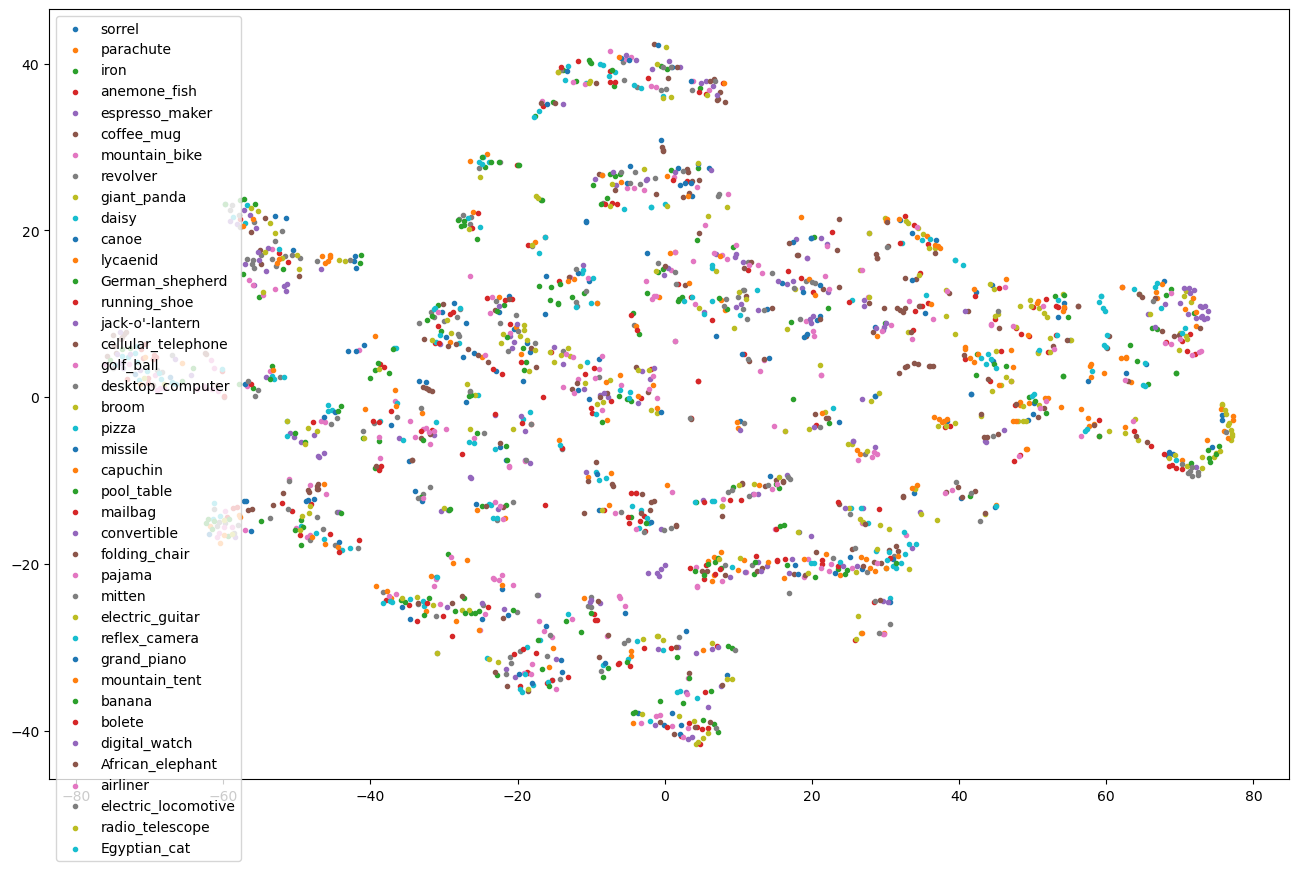

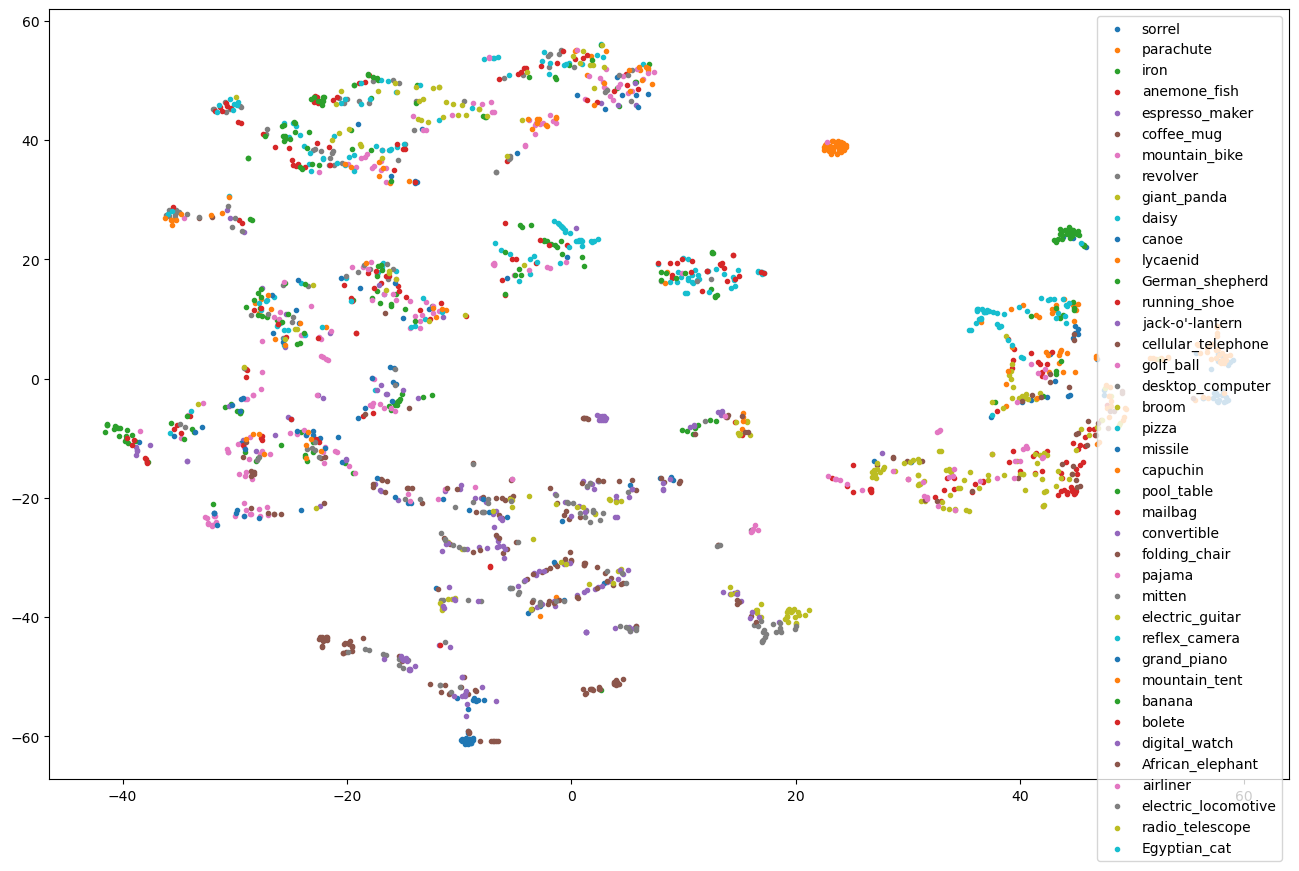

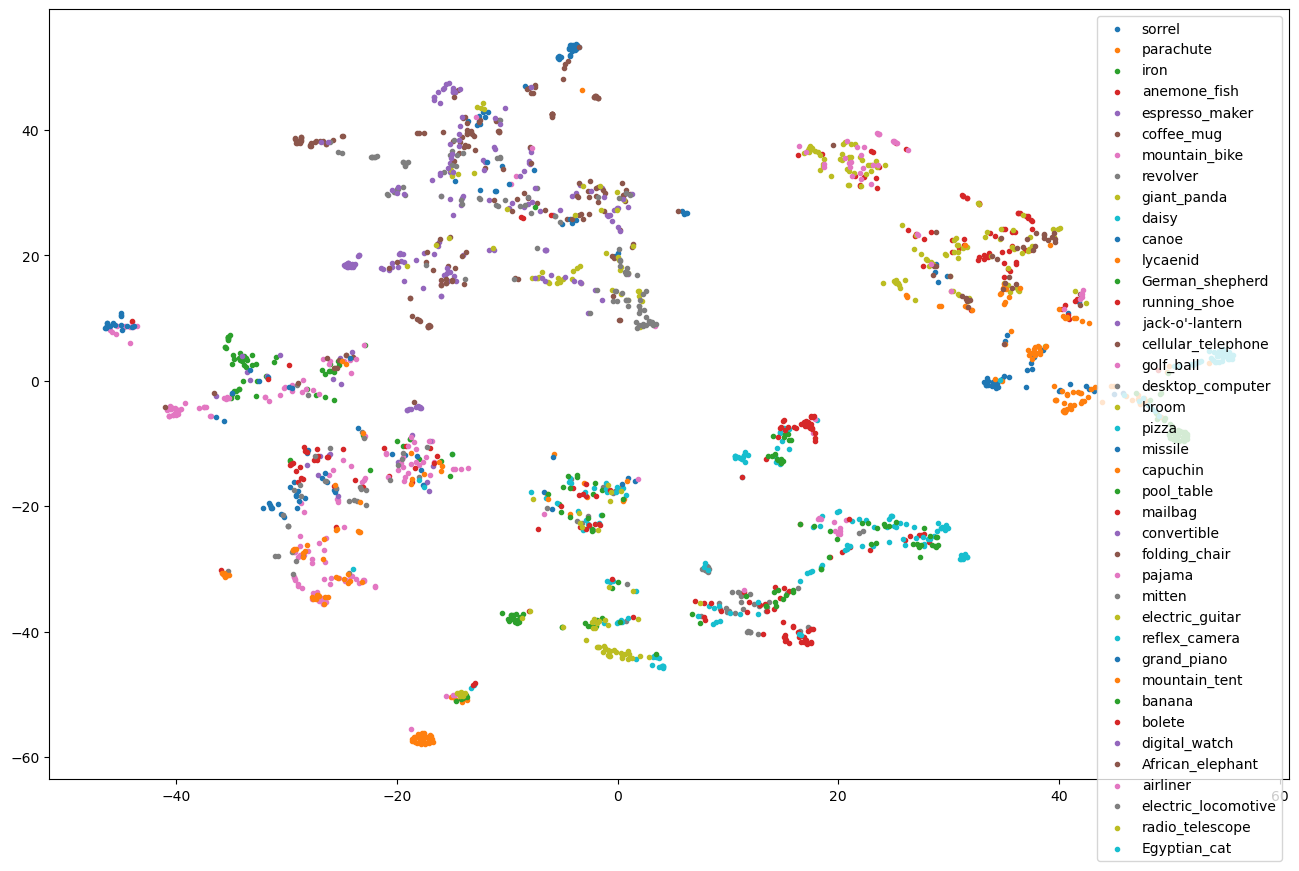

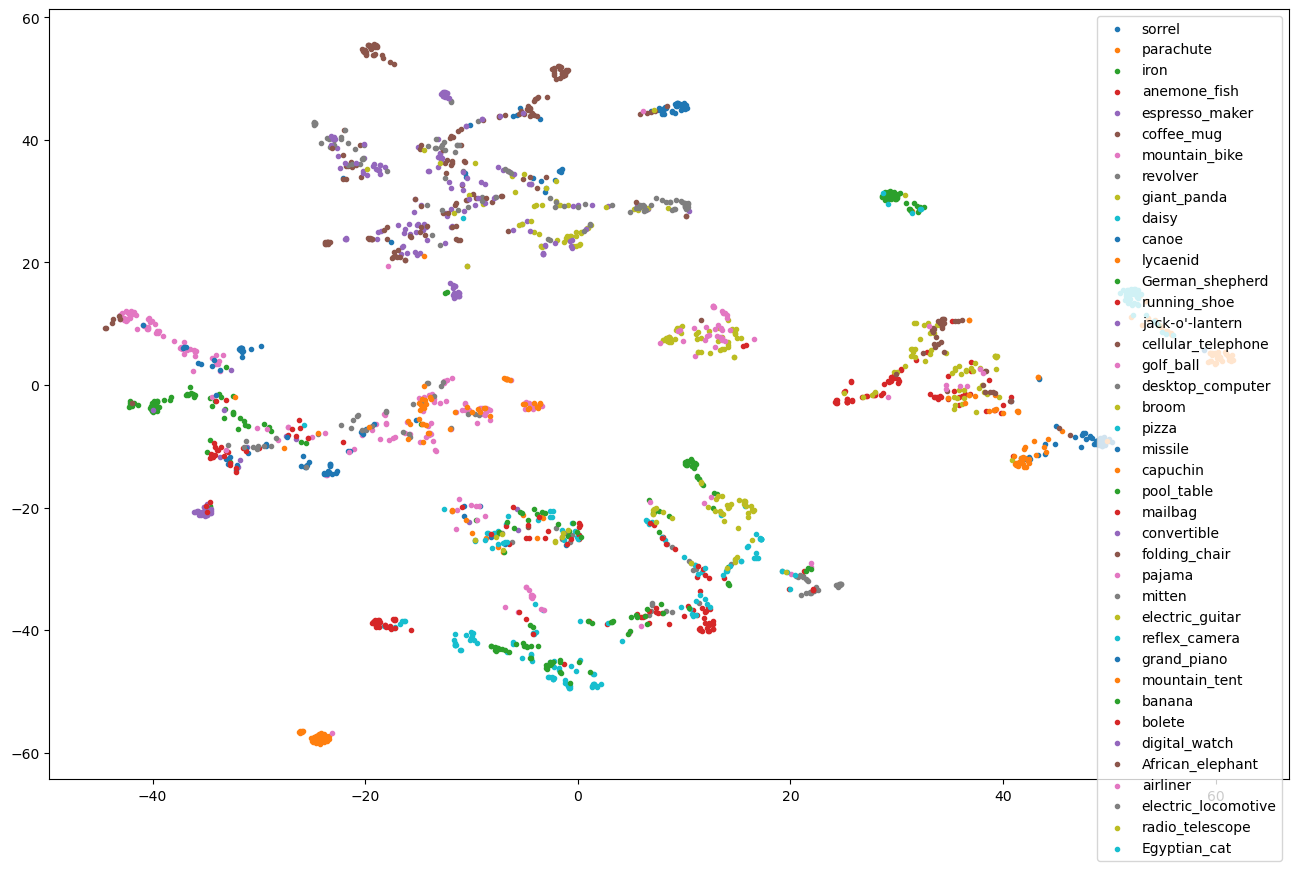

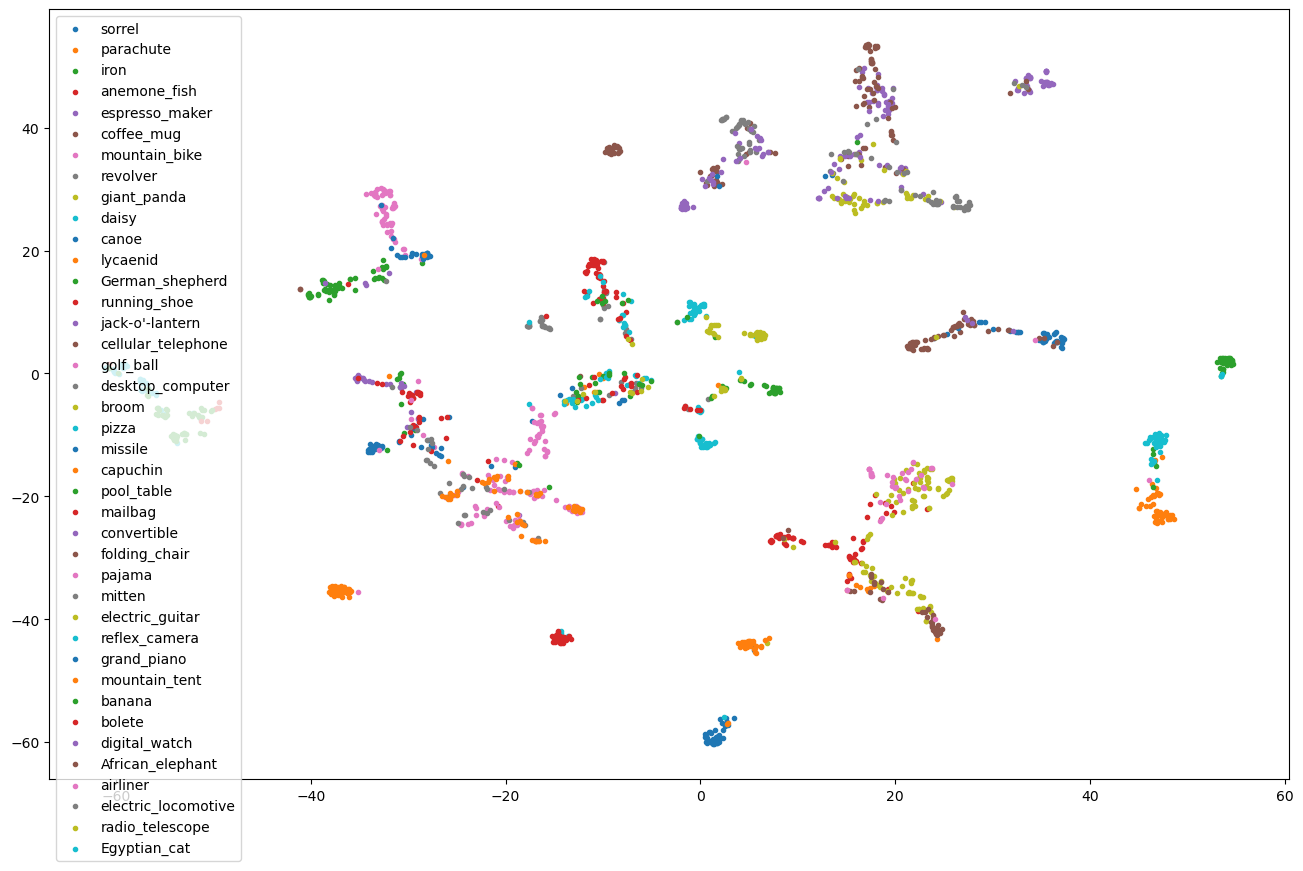

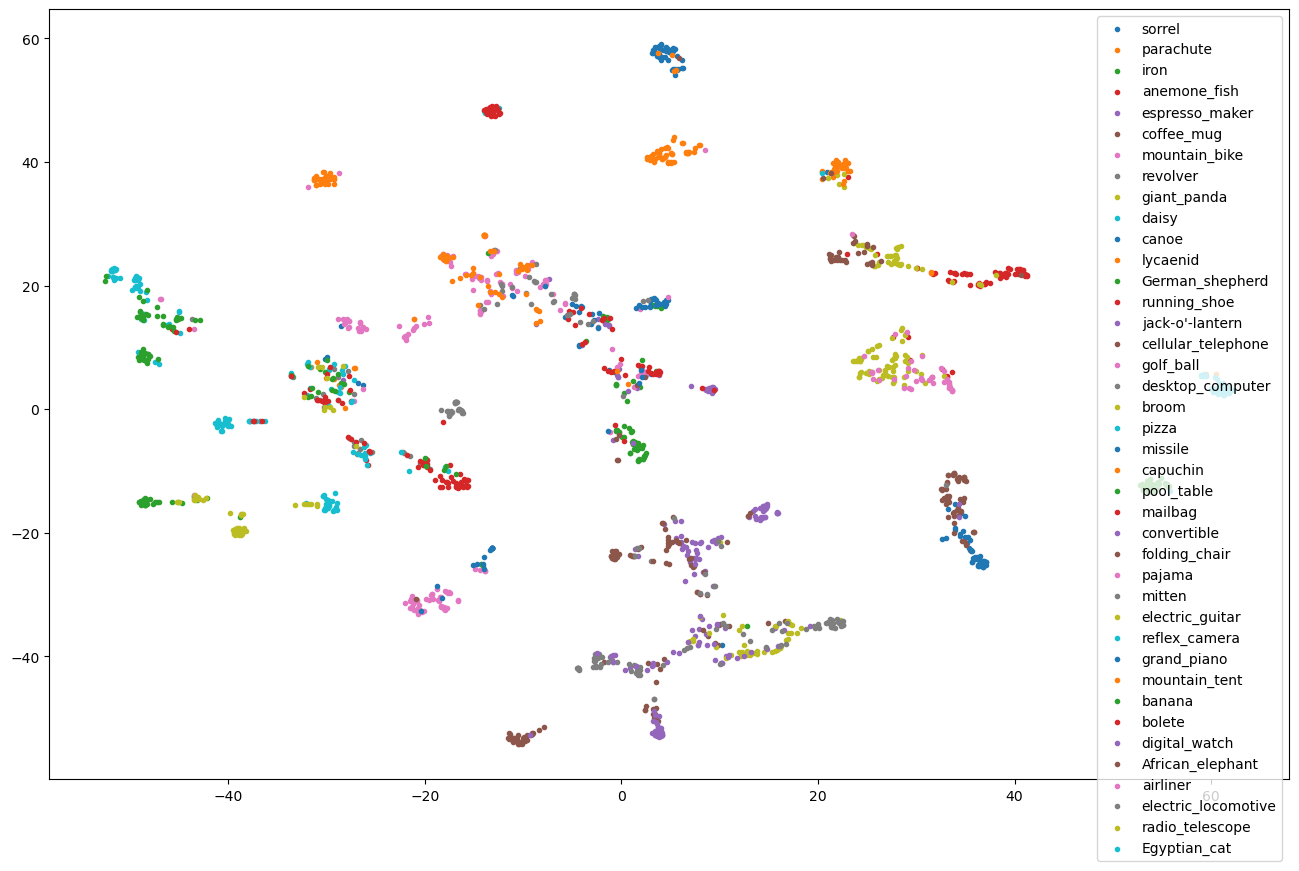

In [50]:
model = SampleLevelFeatureExtractorNN()
model.to(device)

now = datetime.now()
now_hm = now.strftime("%H:%M")

logger = TensorBoardLogger(
    save_dir="/home/choi/BrainDecoder/lightning_logs/SampleLevelFeatureExtraction",
    name=f"{now_hm}_{config['optimizer']}_{config['lr']}_{config['scheduler']}_weight-decay_{config['weight_decay']}_lambda-factor_{config['lambda_factor']}_use-blip_{config['use_blip']}",
    version=now.strftime("%Y-%m-%d %H:%M:%S"),
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[lr_monitor],
    accelerator="gpu",
    devices=[gpu_id],
)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

# Misc

In [ ]:
img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
pil_img = Image.open(img_path)
image = preprocess(pil_img).unsqueeze(0).to(device)
text = clip.tokenize(["german shepard", "a dog", "a cat"]).to(device)

np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

In [ ]:
img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
text = ["an image of a dog", "hi"]
# text = "an image of a dog"
pil_img = Image.open(img_path)
image = preprocess(pil_img).unsqueeze(0).to(device)
text = clip.tokenize(text).to(device)
print(text)
print(text.shape)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    print(text_features)
    print(text_features.shape)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(logits_per_image)
print(logits_per_text)
np.set_printoptions(suppress=True)
print(probs)
print(np.max(probs))
print(np.argmax(probs))
print(image_features.shape)
print(text_features.shape)
print(type(text_features))

In [ ]:
from lavis.models import load_model_and_preprocess

img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_10232.JPEG"
)
pil_img = Image.open(img_path)

blip_model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption", model_type="base_coco", is_eval=True, device=device
)
pil_img = vis_processors["eval"](pil_img).unsqueeze(0).to(device)
blip_model.generate({"image": pil_img})

In [ ]:
from lavis.models import load_model_and_preprocess, model_zoo
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:2"

# print(model_zoo)

blip_model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption",
    model_type="base_coco",
    is_eval=True,
    device=device,
)

img_path = (
    "/home/choi/BrainDecoder/dataset/imageNet_images/n02106662/n02106662_1152.JPEG"
)
pil_img = Image.open(img_path)
processed_img = vis_processors["eval"](pil_img).unsqueeze(0).to(device)
processed_img_2 = torch.cat([processed_img, processed_img])
caption = blip_model.generate({"image": processed_img_2})

print(caption)
img = np.array(pil_img)
plt.imshow(img)

In [ ]:
p = vis_processors["eval"](pil_img)
print(p.shape)
print(p.unsqueeze(0).shape)
p = p.unsqueeze(0)
torch.cat([p, p]).shape
print((p * 4).shape)